In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import importlib
import numpy as np
import sys
import os
import copy

import tensorflow as tf
from sklearn.model_selection import train_test_split

sys.path.append(os.path.abspath('../'))

import utils.ml_util
importlib.reload(utils.ml_util)
from utils.ml_util import *

import utils.trading_util
importlib.reload(utils.trading_util)
from utils.trading_util import *

2024-12-18 23:52:45.601002: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 23:52:45.607159: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-18 23:52:45.624480: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734583965.653210   46671 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734583965.661153   46671 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 23:52:45.691085: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [2]:
TKR = 'T'
MAX_HOLDING = 100
START_DATE = pd.Timestamp('1999-01-01')
END_DATE = pd.Timestamp('2010-01-01')
TIME_EFFECT = 3
RANDOM_SD = 0.045 # Corresponds to +-9% loss

historic_prices = yf.download(TKR)['Adj Close']
training_prices = [float(x) for x in historic_prices[TKR][START_DATE:END_DATE]]

[*********************100%***********************]  1 of 1 completed


Outlook is a function of future returns, weighted less as time progresses

In [3]:
outlook = []
for pos1 in range(len(training_prices) - MAX_HOLDING):
    ans = 0
    for pos2 in range(1, MAX_HOLDING):
        ans += (training_prices[pos1 + pos2] - training_prices[pos1]) * time_effect[TIME_EFFECT](MAX_HOLDING, pos2)
    outlook.append(ans / integrated_time_effect[TIME_EFFECT])
    
n_outlook = normalize_average(outlook, MAX_HOLDING * 3)
bn_outlook = gaussian_randomize(n_outlook, RANDOM_SD)

Text(0, 0.5, 'Blurred Normalized Outlook')

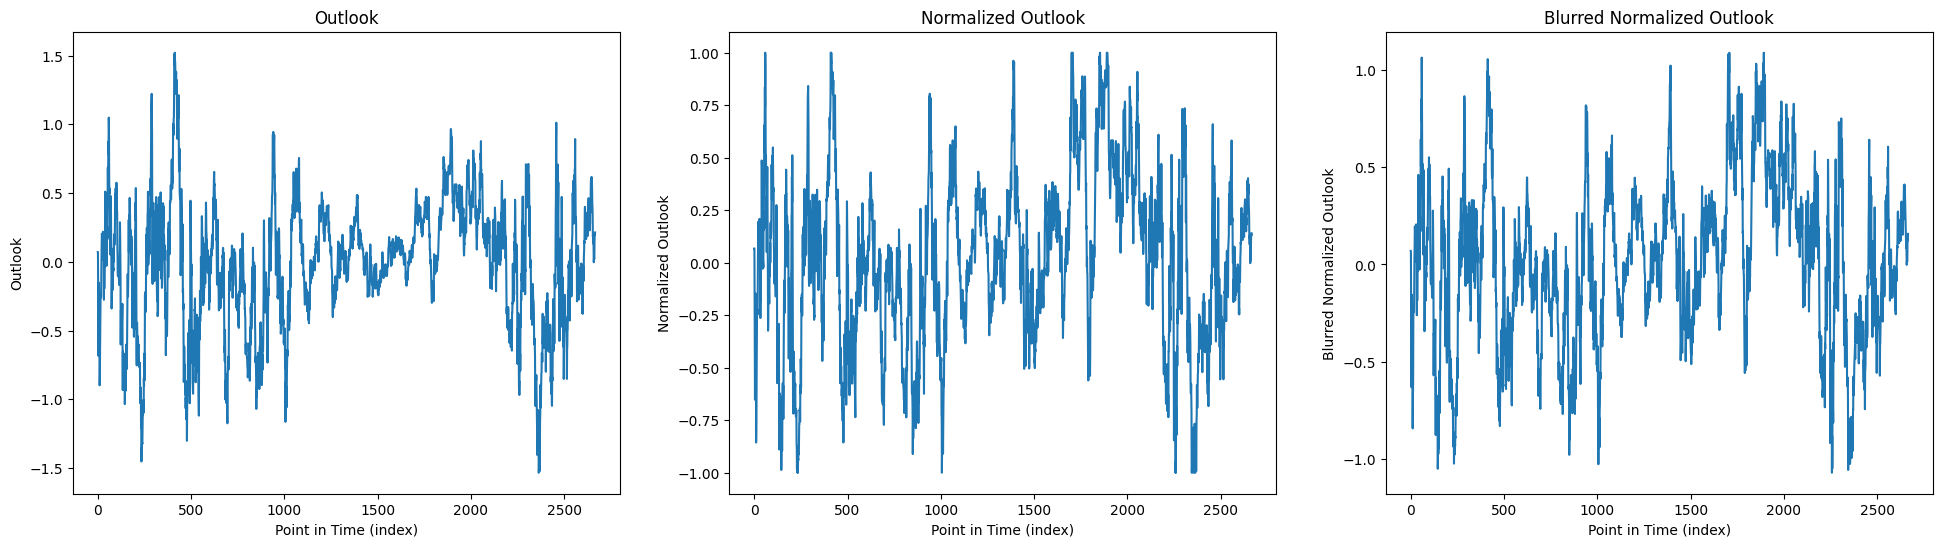

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))

ax1.plot(range(len(outlook)), outlook)
ax1.set_title('Outlook')
ax1.set_xlabel('Point in Time (index)')
ax1.set_ylabel('Outlook')

ax2.plot(range(len(n_outlook)), n_outlook)
ax2.set_title('Normalized Outlook')
ax2.set_xlabel('Point in Time (index)')
ax2.set_ylabel('Normalized Outlook')

ax3.plot(range(len(bn_outlook)), bn_outlook)
ax3.set_title('Blurred Normalized Outlook')
ax3.set_xlabel('Point in Time (index)')
ax3.set_ylabel('Blurred Normalized Outlook')

In [5]:
sell_time = []
for day in range(len(training_prices) - MAX_HOLDING):
    if n_outlook[day] > 0:
        highest = 0
        highest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices[day + delay] - training_prices[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta > highest:
                highest = delta
                highest_pos = delay
        sell_time.append(highest_pos / MAX_HOLDING)
    else:
        lowest = 0
        lowest_pos = 0
        for delay in range(MAX_HOLDING):
            delta = (training_prices[day + delay] - training_prices[day]) * time_effect[TIME_EFFECT](MAX_HOLDING, delay)
            if delta < lowest:
                lowest = delta
                lowest_pos = delay
        sell_time.append(lowest_pos / MAX_HOLDING)
b_sell_time = gaussian_randomize(sell_time, RANDOM_SD)


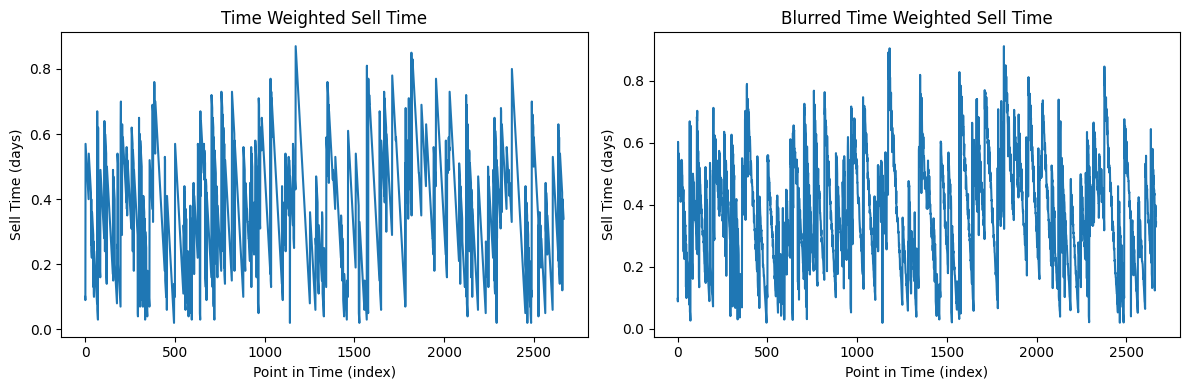

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

axs[0].plot(range(len(sell_time)), sell_time, label='Time Weighted')
axs[0].set_title('Time Weighted Sell Time')
axs[0].set_xlabel('Point in Time (index)')
axs[0].set_ylabel('Sell Time (days)')

axs[1].plot(range(len(b_sell_time)), b_sell_time, label='Blurred Time Weighted')
axs[1].set_title('Blurred Time Weighted Sell Time')
axs[1].set_xlabel('Point in Time (index)')
axs[1].set_ylabel('Sell Time (days)')

plt.tight_layout()
plt.show()

In [12]:
account = Account()
testing_prices = training_prices[:len(bn_outlook)]
stock = Stock(TKR, testing_prices[0])
MAX_TRANSACTION = 1

sell_orders = {}
cover_orders = {}

buy_positions = []
sell_positions = []
executed_sell_orders = []
executed_cover_orders = []

net_worth = []
min_balance = 0

for pos in range(len(testing_prices)):
    stock.update_price(testing_prices[pos])
    
    if bn_outlook[pos] > 0.2:
        account.buy(stock, abs(MAX_TRANSACTION * bn_outlook[pos]))
        sell_orders[int(pos + (b_sell_time[pos] * MAX_HOLDING))] = abs(MAX_TRANSACTION * bn_outlook[pos])
        buy_positions.append((pos, testing_prices[pos]))
    elif bn_outlook[pos] < -0.2:
        account.sell(stock, abs(MAX_TRANSACTION * bn_outlook[pos]))
        cover_orders[int(pos + (b_sell_time[pos] * MAX_HOLDING))] = abs(MAX_TRANSACTION * bn_outlook[pos])
        sell_positions.append((pos, testing_prices[pos]))
    
    # if pos in sell_orders:
    #     account.sell(stock, sell_orders[pos])
    #     executed_sell_orders.append((pos, testing_prices[pos]))
    # if pos in cover_orders:
    #     account.buy(stock, cover_orders[pos])
    #     executed_cover_orders.append((pos, testing_prices[pos]))

    net_worth.append(account.net_worth())
    if account.balance < min_balance:
        min_balance = account.balance

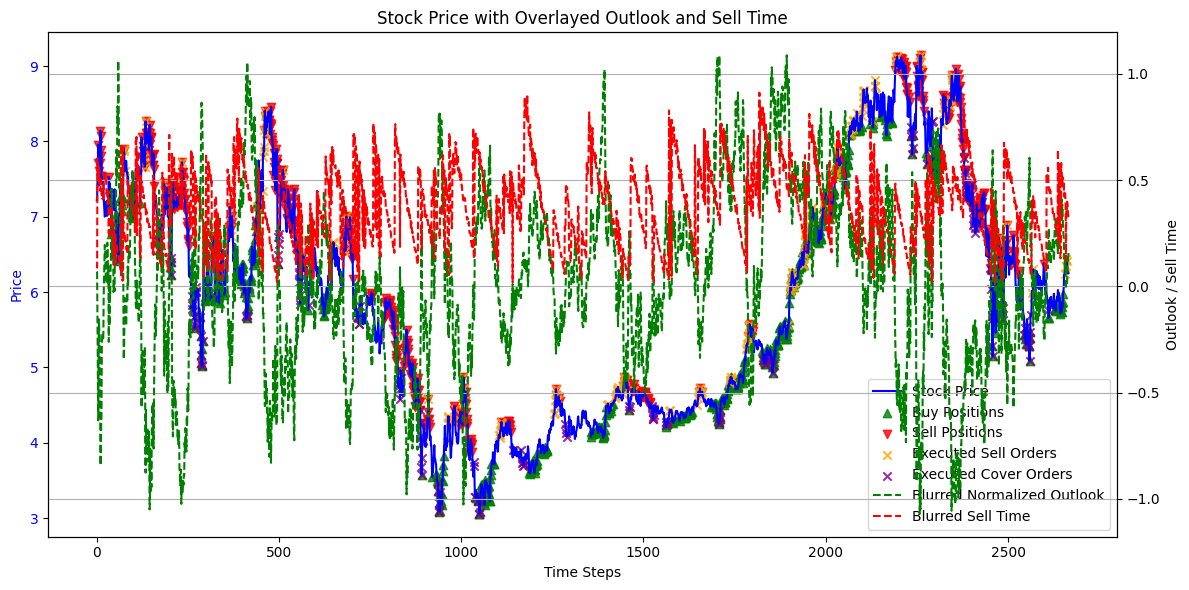

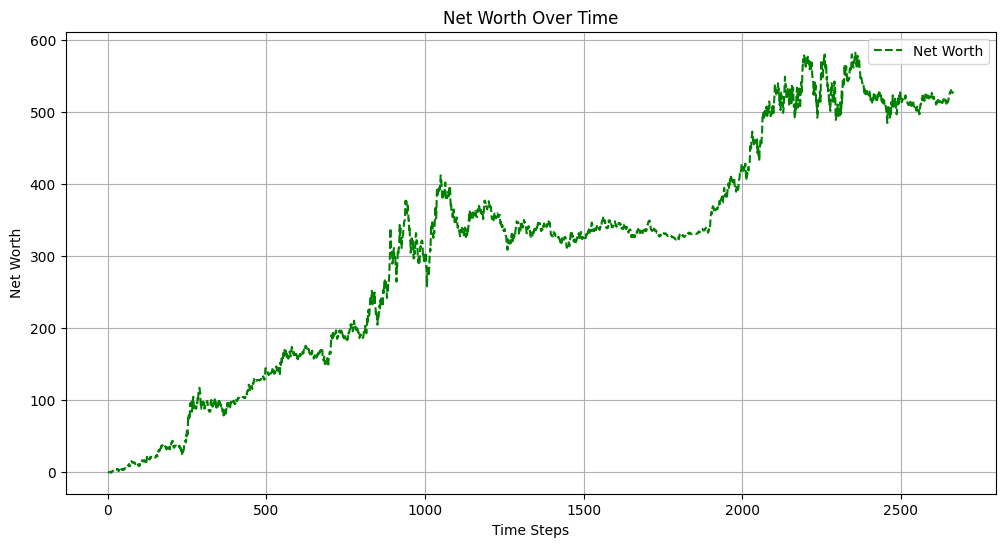

Balance: $358.88
Net Worth: $526.51
Total Profit: 276.44%
Holdings:
T: 26.809756282270303 shares
Stock Profit: -13.38%


In [8]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(range(len(testing_prices)), testing_prices, label="Stock Price", color="blue")
ax1.set_xlabel("Time Steps")
ax1.set_ylabel("Price", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")

buy_x, buy_y = zip(*buy_positions) if buy_positions else ([], [])
ax1.scatter(buy_x, buy_y, label="Buy Positions", color="green", marker="^", alpha=0.8)

sell_x, sell_y = zip(*sell_positions) if sell_positions else ([], [])
ax1.scatter(sell_x, sell_y, label="Sell Positions", color="red", marker="v", alpha=0.8)

exec_sell_x, exec_sell_y = zip(*executed_sell_orders) if executed_sell_orders else ([], [])
ax1.scatter(exec_sell_x, exec_sell_y, label="Executed Sell Orders", color="orange", marker="x", alpha=0.8)

exec_cover_x, exec_cover_y = zip(*executed_cover_orders) if executed_cover_orders else ([], [])
ax1.scatter(exec_cover_x, exec_cover_y, label="Executed Cover Orders", color="purple", marker="x", alpha=0.8)

ax2 = ax1.twinx()
ax2.plot(range(len(outlook)), bn_outlook, label="Blurred Normalized Outlook", color="green", linestyle="--")
ax2.plot(range(len(sell_time)), b_sell_time, label="Blurred Sell Time", color="red", linestyle="--")
ax2.set_ylabel("Outlook / Sell Time", color="black")
ax2.tick_params(axis="y", labelcolor="black")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc="lower right")

plt.title("Stock Price with Overlayed Outlook and Sell Time")
plt.grid()
plt.tight_layout()

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(range(len(net_worth)), net_worth, label="Net Worth", color="green", linestyle="--")

plt.title("Net Worth Over Time")
plt.xlabel("Time Steps")
plt.ylabel("Net Worth")
plt.legend()
plt.grid()

plt.show()

print(account)
print(f"Stock Profit: {(testing_prices[-1] - testing_prices[0]) / testing_prices[0] * 100:.2f}%")

In [9]:
features = get_sma_sd_v(training_prices, [5, 10, 20, 50, 70, 100], MAX_HOLDING)
for pos in range(len(features)):
    features[pos] = features[pos][:-MAX_HOLDING - 1]
n_outlook = n_outlook[MAX_HOLDING:]
sell_time = sell_time[MAX_HOLDING:]

x = np.array(transpose(features))
y = np.array(transpose([n_outlook, sell_time]))

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

def create_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(18,)),
        tf.keras.layers.Flatten(name='layers_flatten'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(256, activation='tanh'),
        tf.keras.layers.Dense(128, activation='tanh'),
        tf.keras.layers.Dense(64, activation='tanh'),
        tf.keras.layers.Dense(2),
    ])

model = create_model()
model.compile(optimizer='adam',
            loss='mean_absolute_error',)

W0000 00:00:1734583973.824478   46671 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [11]:
model.fit(x=x_train, 
        y=y_train, 
        epochs=50, 
        validation_data=(x_test, y_test), 
    )

Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5209 - val_loss: 0.2372
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2359 - val_loss: 0.2336
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2322 - val_loss: 0.2310
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2322 - val_loss: 0.2295
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2326 - val_loss: 0.2274
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2185 - val_loss: 0.2252
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2126 - val_loss: 0.2214
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2072 - val_loss: 0.2156
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2011 - val_loss: 0.2050
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1981 - val_loss: 0.2008
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1951 - val_loss: 0.2228
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2084 - val_lo